In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import json
from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import nomad.io.base as loader
import nomad.stop_detection.utils as utils
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.stop_detection.postprocessing as pp

import nomad.visit_attribution.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, precision_recall_f1_from_minutes

In [2]:
def classify_dwell(duration):
    if duration < 60:
        return 'low'
    elif 60 <= duration <= 180:
        return 'mid'
    else:
        return 'high'

def classify_size(size):
    if size == 1:
        return 'small'
    elif 2 <= size <= 4:
        return 'medium'
    else:
        return 'big'

In [3]:
## Configure stop detection algorithms

In [4]:
with open('config_low_ha.json', 'r', encoding='utf-8') as f:
    config1 = json.load(f)

with open('config_high_ha.json', 'r', encoding='utf-8') as f:
    config2 = json.load(f)

config=config1

config["algos"] = {
    "ta_dbscan_coarse":{
        "func":TADBSCAN.ta_dbscan,
        "params":{
            "time_thresh":240,
            "dist_thresh":18,
            "min_pts":2
        }
    },
    "lachesis_coarse":{
        "func":LACHESIS.lachesis,
        "params":{
            'dt_max': 240,
            'delta_roam': 40
        }
    }
}


## Load sparse data and diaries

In [5]:
poi_table = gpd.read_file('../../garden_city.gpkg').rename(columns={"building_id":"location"})

sparse_path=config["output_files"]["sparse_path"]
diaries_path=config["output_files"]["diaries_path"]
homes_path=config["output_files"]["homes_path"]

sparse_df = loader.from_file(sparse_path, format="parquet")
diaries_df = loader.from_file(diaries_path, format="parquet").rename(columns={"identifier":"user_id"})
homes_df = pd.read_parquet(homes_path)

mask = ~diaries_df.location.isna()
diaries_df.loc[mask,'dwell_length'] = diaries_df.loc[mask,'duration'].apply(classify_dwell)
diaries_df.loc[mask,'building_size'] = diaries_df.loc[mask,'size'].apply(classify_size)

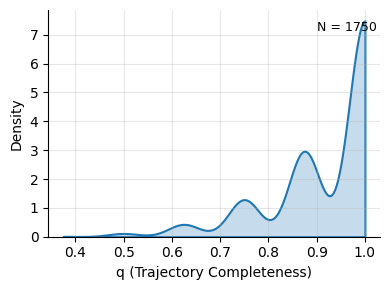

In [6]:
q = filters.completeness(sparse_df,
             periods=30,
             freq="min").to_frame(name="q_stat").reset_index()

plt.figure(figsize=(4,3))
ax = sns.kdeplot(
    data=q,
    x="q_stat",
    fill=True,
    linewidth=1.5,
    bw_adjust=1.3,
    cut=0
)

# cosmetics
ax.set_xlabel("q (Trajectory Completeness)")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.3)
sns.despine(top=True, right=True)

# annotation (top-right corner in axes coords)
ax.text(
    0.99, 0.95,
    f"N = {len(q)}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=9
)

plt.tight_layout()
plt.show()

## Stop detection

In [ ]:
results_list = []
for user in tqdm(diaries_df.user_id.unique()[600:], desc='Processing users'):
    sparse = sparse_df.query("user_id==@user").copy()
    truth = diaries_df.query("user_id==@user").copy()
    
    # ta_dbscan
    algo = config["algos"]["ta_dbscan_coarse"]
    stops = algo["func"](sparse, **algo["params"], x="x", y="y")
    stops["location"] = visits.point_in_polygon(stops, poi_table=poi_table, data_crs='EPSG:3857',
                                       max_distance=10, location_id='location', x='x', y='y')
    

Processing users:  45%|███████████████████████████▏                                 | 513/1150 [00:06<00:07, 81.80it/s]

> c:\users\franc\desktop\brain\code development\nomad\nomad\visit_attribution\visit_attribution.py(79)point_in_polygon()
     77         pdb.set_trace()
     78         # is labeled pings
---> 79         if not cluster_label: #try defaults and raise
     80             if 'cluster_label' in data.columns:
     81                 cluster_label = 'cluster_label'



ipdb>  p data.columns


Index(['x', 'y', 'datetime', 'timestamp', 'user_id', 'ha', 'tz_offset'], dtype='object')


Processing users:  45%|███████████████████████████▏                                 | 513/1150 [00:20<00:07, 81.80it/s]

In [ ]:
sparse